# <font  color = "#0093AF">Chemical Exchange Saturation Transfer (CEST)</font>

<a href="https://githubtocolab.com/alsinmr/SLEEPY_tutorial/blob/main/ColabNotebooks/Chapter2/Ch2_CEST.ipynb" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg"></a>

In the CEST experiment, one often has chemical exchange, but with one very small population, such that its chemical shift is difficult or impossible to observe directly. However, if we were to apply a low-power saturating field when magnetization is in the z-direction, it is possible to saturate the magnetization when on-resonant with the invisible peak.

## Setup

In [2]:
import SLEEPY as sl
import numpy as np
import matplotlib.pyplot as plt

## Build the spin system

In [3]:
ex0=sl.ExpSys(v0H=600,Nucs='13C',T_K=298) #We need a description of the experiment for both states (ex0, ex1)
ex1=ex0.copy()
ex0.set_inter(Type='CS',i=0,ppm=-7)
_=ex1.set_inter(Type='CS',i=0,ppm=7)

## Build the Liouvillian
For CEST to work, we need to be able saturate the spins, which requires $T_2$ relaxation. For a more realistic behavior, we also include $T_1$ recovery of the magnetization, which can inhibit the saturation. Finally, we will allow the magnetization to recover towards its thermal equilibrium.

In [4]:
L=sl.Liouvillian((ex0,ex1))  #Builds the two different Hamiltonians and exports them to Liouville space

tc=1e-3     #Correlation time
p1=0.95  #Population of state 1

L.kex=sl.Tools.twoSite_kex(tc=tc,p1=p1)    #Add exchange to the Liouvillian

L.add_relax(Type='T1',i=0,T1=1.5)   #Add T1 relaxation to the system
L.add_relax(Type='T2',i=0,T2=.05)             #Add T2 relaxation to the system
_=L.add_relax(Type='recovery') #This brings the spins back into thermal equilibrium

## Calculate the required propagators
We'll simulate this system by starting with magnetization along the z-axis and saturating at some frequency. After the saturation period, we'll apply a $\pi/2$ pulse along the y-axis to get x-magnetization. This will be allowed to evolve, and Fourier transformed. We can then integrate the main peak to determine the amount of saturation that has occured.

In [5]:
Usat=list()   #We'll pre-calculate the propagators for saturation
voff0=np.linspace(-20,20,500)*ex0.v0[0]/1e6     #5 ppm*150 MHz / 1e6 =750 Hz
seq=L.Sequence()    #Makes a sequence, which lets us add pulses with user-specified timinig
for voff in voff0:
    seq.add_channel('13C',t=[0,.5],v1=25,voff=voff)  #500 ms saturation, 25 Hz strength
    Usat.append(seq.U())
    
seq=L.Sequence()   #Usually it's a better idea to re-initialize the sequence object for new pulses
seq.add_channel('13C',t=[0,2.5e-6],v1=100000,phase=np.pi/2) 
Upi2=seq.U()     #Propagator to apply the pi/2 pulse
Dt=1/(4*10*150)  #For a 10 ppm shift difference, this should be enough to easily capture both peaks in the spectrum 
Uevol=L.U(Dt=Dt)  #Propagator for evolving the spin system

## Run the sequence, with sweep over $\nu_1$
First, we generate the initial magnetization and the detection operator. Then, at each value of $\nu_1$, we reset the detection operator, followed by saturation (U taken out of Usat), apply the $\pi/2$ pulse (Upi2), and finally detect with Uevol. We store the Fourier-transformed signal in spec.

In [6]:
rho=sl.Rho(rho0='13Cz',detect='13Cp')
spec=list()
for U in Usat:
    rho.clear()
    Upi2*U*rho
    rho.DetProp(Uevol,n=1024)
    spec.append(rho.FT[0].real)

## Plot one of the spectra
In order to see the usefulness of this techique, we once plot the spectrum to show that the weaker peak is nearly invisible. We just take the last spectrum that is still stored in rho. The second peak is weakly visible if we zoom in around 5 ppm (but would be quite difficult to see in a real spectrum).

Note that later we integrate the spectrum by selecting a range of points in the spectrum. In this case, it may be useful to set `axis='points'` to more easily determine what range of points to use.

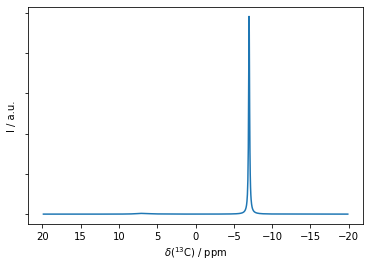

In [12]:
ax=rho.plot(FT=True,axis='ppm')
_=ax.set_yticklabels('')

## Integrate spectrum for all values of $\nu_1$ and plot results
We will just integrate over the strong peak and plot the peak intensity

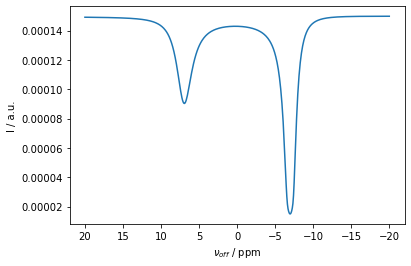

In [13]:
spec=np.array(spec)   #Convert to a numpy array
I=spec[:,400:620].sum(1)  #Integrate over the main peak

ax=plt.subplots()[1]
ax.plot(voff0*1e6/ex0.v0[0],I)
ax.set_xlabel(r'$\nu_{off}$ / ppm')
ax.set_ylabel('I / a.u.')
ax.invert_xaxis()

## Investigate CEST as a function of exchange rate
We repeat the above setup, just varying the exchange rates

In [14]:
p1=0.95  #Population of state 1
p2=1-p1  #Population of state 2

tc0=np.logspace(0,-5.5,12)
I=list()
for tc in tc0:
    kex=1/(2*tc)*(np.array([[-1,1],[1,-1]])+(p1-p2)*np.array([[1,1],[-1,-1]]))   #Exchange matrix
    L.kex=kex    #Add exchange to the Liouvillian
    
    Usat=list()   #We'll pre-calculate the propagators for saturation
    voff0=np.linspace(-20,20,500)*ex0.v0[0]/1e6     #5 ppm*150 MHz / 1e6 =750 Hz
    seq=L.Sequence()    #Makes a sequence, which lets us add pulses with user-specified timinig
    for voff in voff0:
        seq.add_channel('13C',t=[0,.5],v1=25,voff=voff)  #500 ms saturation, 25 Hz strength
        Usat.append(seq.U().calcU()) 
        #Propagtors do not automatically get calculated. In this case, 
        

    seq=L.Sequence()   #Usually it's a better idea to re-initialize the sequence object for new pulses
    seq.add_channel('13C',t=[0,2.5e-6],v1=100000,phase=np.pi/2) 
    Upi2=seq.U()     #Propagator to apply the pi/2 pulse
    Dt=1/(4*10*150)  #For a 10 ppm shift difference, this should be enough to easily capture both peaks in the spectrum 
    Uevol=L.U(Dt=Dt)  #Propagator for evolving the spin system

    rho=sl.Rho(rho0='13Cz',detect='13Cp')
    spec=list()
    for U in Usat:
        rho.clear()
        Upi2*U*rho
        rho.DetProp(Uevol,n=1024)
        spec.append(rho.FT[0].real)

    spec=np.array(spec)   #Convert to a numpy array
    I.append(spec[:,400:620].sum(1))  #Integrate over the main peak

We plot the results below, where we see that the saturation behavior depends strongly on the exchange rate. Note that if the exchange is too fast or too slow, the CEST experiment is no longer as effective.

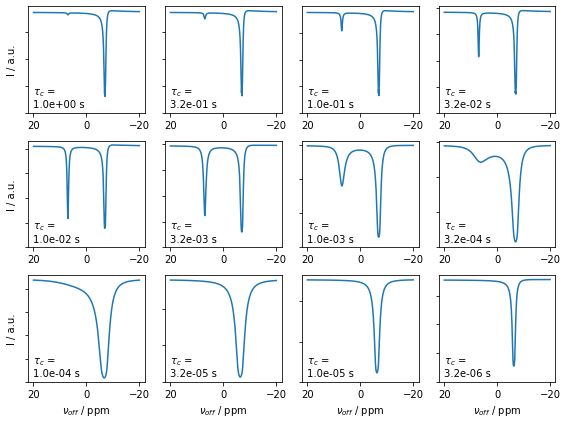

In [15]:
fig,ax=plt.subplots(3,4)
ax=ax.reshape(ax.size)

for a,I0,tc in zip(ax,I,tc0):
    a.plot(voff0*1e6/ex0.v0[0],I0)
    if a.is_last_row():
        a.set_xlabel(r'$\nu_{off}$ / ppm')
    if a.is_first_col():
        a.set_ylabel('I / a.u.')
    a.invert_xaxis()
    a.set_yticklabels('')
    a.set_ylim([0,a.get_ylim()[1]])
    a.text(20,a.get_ylim()[1]*.05,r'$\tau_c$'+f' = \n{tc:.1e} s')
fig.set_size_inches([8,6])
fig.tight_layout()